# PatternNet and PatternLRP: Step by Step Guide

*!This notebook will download 1GB of parameters!*

We will show how to **apply** PatterNet and PatternLRP to ImageNet with a VGG16 network.

In the following we will first:

* import and load the data.
* create a VGG16 model with lasagne.
* **create PatternNet and PatternLRP explainers for VGG16 and apply them to an image**.
* plot the result.

Consider also the two other notebooks:

* step_by_step_cifar10: shows how to **compute** patterns and how to apply them on Cifar10.
* all_methods: gives an overview how the results of different explanation methods look like on ImageNet.

### Imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os

import nn_patterns
import nn_patterns.utils.fileio
import nn_patterns.utils.tests.networks.imagenet
import lasagne
import theano

import imp
eutils = imp.load_source("utils", "./utils.py")

### Data and Parameter loading

We will now download VGG16 parameters and patterns. Finally, we retrieve one image from the ImageNet validation set.

In [2]:
param_file = "./imagenet_224_vgg_16.npz"
# Note those weights are CC 4.0:                                                                                                                                                                                                                                                 
# See http://www.robots.ox.ac.uk/~vgg/research/very_deep/                                                                                                                                                                                                                        
param_url = "https://www.dropbox.com/s/cvjj8x19hzya9oe/imagenet_224_vgg_16.npz?dl=1"

pattern_file = "./imagenet_224_vgg_16.pattern_file.A_only.npz"
pattern_url = "https://www.dropbox.com/s/v7e0px44jqwef5k/imagenet_224_vgg_16.patterns.A_only.npz?dl=1"


# Download the necessary parameters for VGG16 and the according patterns.                                                                                                                                                                                                    
eutils.download(param_url, param_file)
eutils.download(pattern_url, pattern_file)

# Get some example test set images.                                                                                                                                                                                                                                          
images, label_to_class_name = eutils.get_imagenet_data()
image = images[0][0]

## VGG16
We build the VGG16 model and set the trained parameters.

In [3]:
# Create the prediction model and set params.
vgg16 = nn_patterns.utils.tests.networks.imagenet.vgg16()
parameters = nn_patterns.utils.fileio.load_parameters(param_file)
lasagne.layers.set_all_param_values(vgg16["out"], parameters)
predict_f = theano.function([vgg16["input_var"]],
                            lasagne.layers.get_output(vgg16["out"],
                                                      deterministic=True))

## Explanations

We load the patterns and create explainers. Then we apply them to the image. Finally, we postprocess the explanations.

In [4]:
# Lets use pretrained patterns.
# On how to train patterns, please see the cifar10 example.
patterns = nn_patterns.utils.fileio.load_patterns(pattern_file)

# Create explainers.
pattern_net_explainer = nn_patterns.create_explainer("patternnet",
                                                     vgg16["out"],
                                                     patterns=[patterns])
pattern_lrp_explainer = nn_patterns.create_explainer("patternlrp",
                                                     vgg16["out"],
                                                     patterns=[patterns])

# Image needs to be preprocessed for VGG16
x = eutils.preprocess(image)[None, :, :, :]
target = "max_output"  # Explain output neuron with max activation.
# Create explanations.
pattern_net_exp = pattern_net_explainer.explain(x, target=target)[0]
pattern_lrp_exp = pattern_lrp_explainer.explain(x, target=target)[0]

# Postprocess.
pattern_net_exp = eutils.back_projection(pattern_net_exp)
pattern_lrp_exp = eutils.heatmap(pattern_lrp_exp)

## Plot

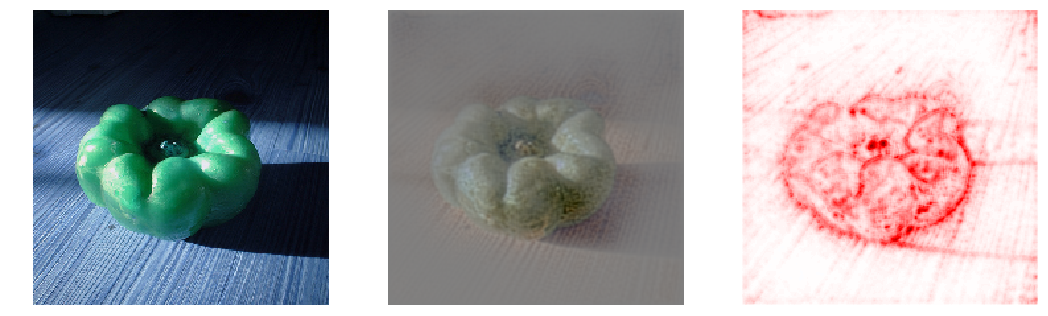

In [5]:
plt.clf()
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    axs[i].tick_params(axis="x", which="both",
                       bottom="off", top="off", labelbottom="off")
    axs[i].tick_params(axis="y", which="both",
                       bottom="off", top="off", labelbottom="off")
    axs[i].axis("off")

# To BGR and [0, 1]
axs[0].imshow(image[:, :, ::-1] / 255,
                 interpolation="nearest")
# Channels last.
axs[1].imshow(pattern_net_exp.transpose(1, 2, 0),
                 interpolation="nearest")
# Channels last.
axs[2].imshow(pattern_lrp_exp.transpose(1, 2, 0),
                 interpolation="nearest")

plt.show()